In [38]:
import numpy as np
import re

# from pickle import dump
import keras.utils
import keras.models

# from keras.models import Sequential
from keras.layers import Dense, LSTM, Lambda
# from keras.layers import LSTM
# from keras.callbacks import EarlyStopping
import keras.preprocessing.sequence as kseq

import difflib
import matplotlib.pyplot as plt
import itertools

In [24]:
# load file
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    text = text.lower()
    text = ''.join([i for i in text if not i.isdigit()])
    file.close()
    return text

# load text
raw_text_corpus = load_doc('./data/shakespeare.txt')

# fix up the formatting, spacing, etc
lines = raw_text_corpus.splitlines()
raw_text_corpus = ''
for line in lines:
    raw_text_corpus = raw_text_corpus + ' '.join(line.split()) + '\n'
raw_text_corpus = re.sub(r'\n\s*\n', '\n', raw_text_corpus)

# generate 40-character sequences
length = 40
char_seqs = []
for i in range(length, len(raw_text_corpus)):
    seq = raw_text_corpus[i-length:i+1]
    char_seqs.append(seq)
    
n = 10 # use semi-redundant sequences (start new sequence every n)
char_seqs = char_seqs[::n]
print('Total char_seqs: %d' % len(char_seqs))
# print(char_seqs[:20])


Total char_seqs: 9364


In [25]:
# encode character sequences as integers
chars = sorted(list(set(raw_text_corpus)))
char_mapping = dict((c, i) for i, c in enumerate(chars))
sequences = []
for line in char_seqs:
    sequences.append([char_mapping[char] for char in line])

# split X and y
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
sequences = [keras.utils.to_categorical(x, num_classes=len(char_mapping)) for x in X]
X = np.array(sequences)
y = keras.utils.to_categorical(y, num_classes=len(char_mapping))

In [55]:
def create_model(temp, epochs):
    # define and compile model
    model = Sequential()
    model.add(LSTM(100, input_shape=(X.shape[1], X.shape[2])))
    model.add(Lambda(lambda x: x / temp))
    model.add(Dense(len(char_mapping), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    # train model, save training history metrics
    history = model.fit(X, y, epochs=epochs, verbose=2)
    
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
    
    return model

#     # save the model to file
#     model.save('model.h5')
#     # save the char_mapping
#     dump(char_mapping, open('char_mapping.pkl', 'wb'))

In [27]:
# plt.plot(history.history['loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [44]:
def generate_seq(model, char_mapping, seq_length, seed_text, n_lines):
    gibberish = seed_text
    # generate fixed number of lines (14 for sonnets)
    while gibberish.count('\n') < n_lines:
        # encode chars as integers; truncate to sequence lengths; use one-hot encoding
        encoded_ints = [char_mapping[char] for char in gibberish]
        encoded_truncated = kseq.pad_sequences([encoded_ints], maxlen=seq_length, truncating='pre')
        encoded = keras.utils.to_categorical(encoded_truncated, num_classes=len(char_mapping))
        
        # predict character
        yhat = model.predict_classes(encoded, verbose=0)
        
        # un-encode integers back to chars
        out_char = ''
        for char, index in char_mapping.items():
            if yhat == index:
                out_char = char
                break
        gibberish += char
    
    
    ###
    # Clean up gibberish
#     raw_text_corpus = load_doc('./data/shakespeare.txt')
    dictionary = raw_text_corpus.split()
    lines = gibberish.splitlines()
    real_word_text = ''
    distances = []
    
    for i in range(n_lines):
        words = lines[i].split()
        line = ''
        for word in words:
            close_matches = difflib.get_close_matches(word, dictionary, n=1)
            if len(close_matches) > 0: # sometimes a word is too far off any real ones -- skip these
                real_word = difflib.get_close_matches(word, dictionary, n=1)[0]
                distances.append(difflib.SequenceMatcher(None, word, real_word).ratio())
#             print(word, real_word)
                line += real_word + ' '
        real_word_text = real_word_text + line + '\n'

    return gibberish, real_word_text, distances

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100)               55600     
_________________________________________________________________
lambda_5 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 38)                3838      
Total params: 59,438
Trainable params: 59,438
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 - 7s - loss: 3.0128 - accuracy: 0.1640
Epoch 2/100
 - 6s - loss: 2.7827 - accuracy: 0.2170
Epoch 3/100
 - 6s - loss: 2.5400 - accuracy: 0.2999
Epoch 4/100
 - 6s - loss: 2.4084 - accuracy: 0.3208
Epoch 5/100
 - 6s - loss: 2.3311 - accuracy: 0.3297
Epoch 6/100
 - 6s - loss: 2.2776 - accuracy: 0.3372
Epoch 7/100
 - 6s - loss: 2.2335 - accuracy: 0.3426
Epoch 8/100

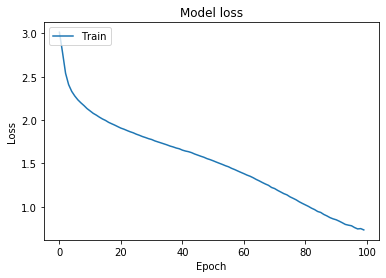

In [34]:
model1 = create_model(1.5, 100)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               55600     
_________________________________________________________________
lambda_8 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 38)                3838      
Total params: 59,438
Trainable params: 59,438
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 - 7s - loss: 2.9782 - accuracy: 0.1701
Epoch 2/50
 - 6s - loss: 2.6181 - accuracy: 0.2726
Epoch 3/50
 - 6s - loss: 2.3579 - accuracy: 0.3223
Epoch 4/50
 - 6s - loss: 2.2541 - accuracy: 0.3488
Epoch 5/50
 - 7s - loss: 2.1816 - accuracy: 0.3599
Epoch 6/50
 - 7s - loss: 2.1269 - accuracy: 0.3744
Epoch 7/50
 - 7s - loss: 2.0746 - accuracy: 0.3905
Epoch 8/50
 - 6s 

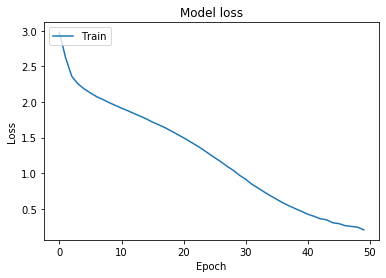

In [56]:
model2 = create_model(0.75, 50)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               55600     
_________________________________________________________________
lambda_9 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 38)                3838      
Total params: 59,438
Trainable params: 59,438
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
 - 7s - loss: 2.8476 - accuracy: 0.2120
Epoch 2/40
 - 7s - loss: 2.3816 - accuracy: 0.3151
Epoch 3/40
 - 7s - loss: 2.2328 - accuracy: 0.3490
Epoch 4/40
 - 6s - loss: 2.1531 - accuracy: 0.3649
Epoch 5/40
 - 6s - loss: 2.0894 - accuracy: 0.3788
Epoch 6/40
 - 6s - loss: 2.0381 - accuracy: 0.3903
Epoch 7/40
 - 7s - loss: 1.9903 - accuracy: 0.4026
Epoch 8/40
 - 7s 

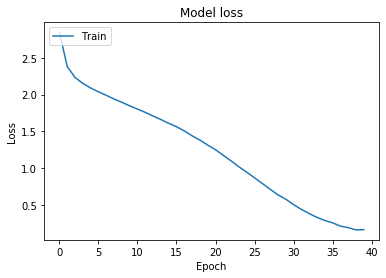

In [57]:
model3 = create_model(0.25, 40)

In [49]:
gibberish1, real_words1, distances1 = generate_seq(model1, char_mapping, 40, 'shall i compare thee to a summer\'s day?\n', 14)

print(gibberish1)
print(real_words1)
mean_distances1 = np.array(list(itertools.accumulate(distances1))) / np.arange(1,len(distances1)+1)


shall i compare thee to a summer's day?
he geaver herchoust that i walt beauty to desioved and my love the rime rage,
thou thou that have your sead,
that is my trues,
and love that is my self soifs,
that is plountredcass,
so thing nged,
the cacontrunce should but that i nor hangs ot me thy live, and thou that hand in manged,
and have you hack of amarty the swert of thee yours fould but and thou thou thy live you wiel werse show,
that is ponters heads
that is ponting swee,
on love's and i have and my life pairs of me beauty beauty to thee for the sore,
the canding word thou my uthate which gayse of sull mines,
and thou then shat my love this thou crazs hair hast thou thou thy sofes,

shall i compare thee to a summer's day? 
he gave thrusts that i wealth beauty to desired and my love the prime. rage, 
thou thou that have your sea, 
that is my true, 
and love that is my self spoils 
that is 
so thing ranged, 
the contracted should but that i nor hang out me thy live, and thou that hand in

In [58]:
gibberish2, real_words2, distances2 = generate_seq(model2, char_mapping, 40, 'shall i compare thee to a summer\'s day?\n', 14)

print(gibberish2)
print(real_words2)
mean_distances2 = np.array(list(itertools.accumulate(distances2))) / np.arange(1,len(distances2)+1)


shall i compare thee to a summer's day?
they will farling in frailiok in theat,
thou to thy thoull ti is faid thee simpre,
shing, and hage faithour shim thou so thy sell mes,
of sumper as he the erver and yight,
if seacing,
or in make the eaving thee thy preense,
they has shoust thime restest to dide,
and and hipp thou mart that mesunt summes spere,
beint merthou to chat eaver lot is thise,
will with with will werle sabling auty her, mane,
thin thy grome,
an and com mount thou thou macrtongers,
bo mine,

shall i compare thee to a summer's day? 
they will faring in frailties in that, 
thou to thy thou tie is said thee sire, 
sing, and age faith him thou so thy smell me, 
of summer as he the ever and sight, 
if swearing, 
or in make the leaving thee thy present, 
they hast shouldst time greatest to die, 
and and happy thou mar that meant summers' speed, 
bent thou to chaste ever lost is this, 
will with with will were salving beauty her, man, 
think thy rose, 
an and come mounted thou th

In [59]:
gibberish3, real_words3, distances3 = generate_seq(model3, char_mapping, 40, 'shall i compare thee to a summer\'s day?\n', 14)

print(gibberish3)
print(real_words3)
mean_distances3 = np.array(list(itertools.accumulate(distances3))) / np.arange(1,len(distances3)+1)


shall i compare thee to a summer's day?
thoughinss majlooo,
and growe thou macrirnccosed bothand vains,
or didg thy beadiegrion man thise,
and mine of gress my tot beaur'st of shee,
my love thos every ulus for st me prouty,
tuke thoutris and thou that i heart wrilg to of rememed.
of thy theee of theet to beluce to blaine.
thuness wren in thing stourses foo mone,
opasseet the that cars bo bdat oov ande.
the commere that is dost but the pove's,
thou this i journoon conthed bease,
the comerere then theuth thee sue this fort:
ood sud thee iod mere,

shall i compare thee to a summer's day? 
thoughts moon, 
and grow thou married than veins, 
or dig thy bearing man this, 
and mine of press my to bear'st of see, 
my love those every lust for set me pry, 
tune hours and thou that i heart writ to of deemed. 
of thy thee of thee to belied to blind. 
unless when in thing stores, foot one, 
passed the that cars boy date woo hand. 
the commence: that is dost but the proves 
thou this i journey count

In [47]:
# import numpy as np
# nums = [4, 13, 23, 21, 11]
# cum_distances = np.array(list(itertools.accumulate(distances)))
# [4, 17, 40, 61, 72]

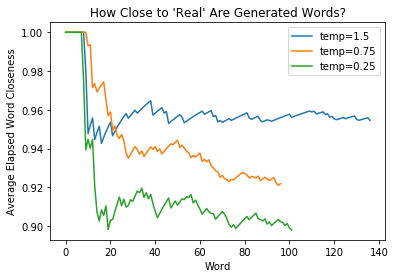

In [64]:
plt.figure()
plt.plot(mean_distances1, label='temp=1.5')
plt.plot(mean_distances2, label='temp=0.75')
plt.plot(mean_distances3, label='temp=0.25')

plt.title('How Close to \'Real\' Are Generated Words?')
plt.ylabel('Average Elapsed Word Closeness')
plt.xlabel('Word')
plt.legend(loc='upper right')
plt.show()